# Neoclassical Growth Model

Seho Jeong, Sogang University

**References**
- https://colab.research.google.com/drive/1jbSti3LkxASZg04Bkod0EBJFXdf6xu9_?usp=sharing

In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from dataclasses import dataclass

## Discrete-Time Solution with Discrete State Approximation

In [21]:
# Model parameters
β = 0.95  # time discount factor
α = 1/3   # capital share in production function
δ = 1.    # depreciation rate
A = 1     # productivity

In [43]:
# Numerical parameters
max_iter = 100   # maximum number of iterations
tol = 1e-7       # convergence tolerance
penalty = 1e20 # penalty for constraint violations

In [44]:
utility = lambda c: np.log(c)
production = lambda k: A * k ** α

# True V
D = α / (1 - α * β)
C = ((1 + β * D) * np.log(A) + β * D * np.log(β * D / (1 + β * D)) - np.log(1 + β * D)) / (1 - β)
Vtrue = lambda k: C + D * np.log(k)
ktrue = lambda k: (β * D / (1 + β * D)) * A * (k ** α)
ctrue = lambda k: production(k) + (1 - δ) * k - ktrue(k)

In [45]:
# Set up the grid of capital stocks
knum = 1001 # number of nodes for k grid
kmin = tol  # effectively zero
kmax = 90.0 # effective upper bound on k grid

kgrid = np.linspace(kmin, kmax, knum) # linearly spaced

In [46]:
# Return function
c = np.zeros((knum, knum))
for j in range(knum):
    c[:, j] = production(kgrid) + (1 - δ) * kgrid - kgrid[j]

In [47]:
# Penalize violations of feasibility constraints.
violations = (c <= 0)
c = c * (c >= 0) + 1e-10

u = utility(c) - penalty * violations

In [48]:
u

array([[-5.37272007e+00, -1.00000000e+20, -1.00000000e+20, ...,
        -1.00000000e+20, -1.00000000e+20, -1.00000000e+20],
       [-8.02648389e-01, -1.02682980e+00, -1.31624403e+00, ...,
        -1.00000000e+20, -1.00000000e+20, -1.00000000e+20],
       [-5.71599468e-01, -7.45237378e-01, -9.55495228e-01, ...,
        -1.00000000e+20, -1.00000000e+20, -1.00000000e+20],
       ...,
       [ 1.49926920e+00,  1.47896813e+00,  1.45824636e+00, ...,
        -1.00000000e+20, -1.00000000e+20, -1.00000000e+20],
       [ 1.49960303e+00,  1.47930880e+00,  1.45859417e+00, ...,
        -1.00000000e+20, -1.00000000e+20, -1.00000000e+20],
       [ 1.49993653e+00,  1.47964914e+00,  1.45894163e+00, ...,
        -1.00000000e+20, -1.00000000e+20, -1.00000000e+20]])

In [49]:
# Solve Bellman equation using value function iteration.

# Initial guess
V = np.zeros(knum)

# Iterate on Bellman operator
for it in range(max_iter):

    # RHS of Bellman equation
    RHS = u + β * np.kron(np.ones((knum, 1)), V)

    TV = np.max(RHS, axis=1)
    kj = np.argmax(RHS, axis=1)
    g = kgrid[kj] # policy that attains the maximum

    # Check if converged.
    error = np.max(np.abs(TV - V))
    print(f'Iteration {it+1:3d} = {error}')

    if error < tol: break

    V = TV

Iteration   1 = 5.372720073353612
Iteration   2 = 5.104084069685932
Iteration   3 = 4.848879866201635
Iteration   4 = 4.606435872891552
Iteration   5 = 4.376114079246975
Iteration   6 = 4.157308375284625
Iteration   7 = 3.9494429565203966
Iteration   8 = 3.7519708086943737
Iteration   9 = 3.5643722682596533
Iteration  10 = 3.386153654846673
Iteration  11 = 3.2168459721043376
Iteration  12 = 3.05600367349912
Iteration  13 = 2.9032034898241648
Iteration  14 = 2.758043315332955
Iteration  15 = 2.620141149566308
Iteration  16 = 2.489134092087994
Iteration  17 = 2.364677387483596
Iteration  18 = 2.246443518109423
Iteration  19 = 2.1341213422039402
Iteration  20 = 2.0274152750937446
Iteration  21 = 1.9260445113390574
Iteration  22 = 1.829742285772113
Iteration  23 = 1.7382551714835017
Iteration  24 = 1.6513424129093153
Iteration  25 = 1.5687752922638651
Iteration  26 = 1.490336527650669
Iteration  27 = 1.4158197012681342
Iteration  28 = 1.3450287162047232
Iteration  29 = 1.2777772803945027
I

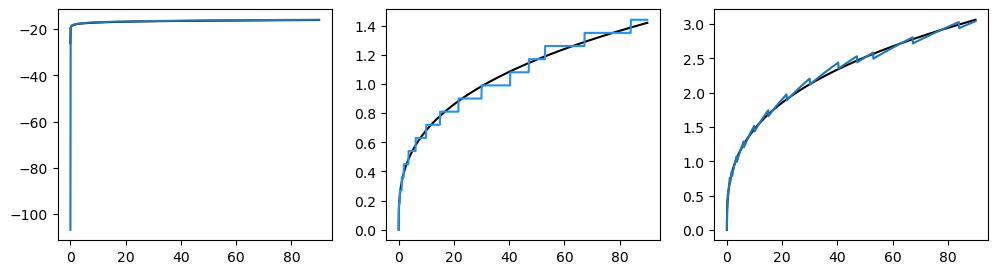

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))

# LEFT PANEL: VALUE FUNCTION
ax1.plot(kgrid, Vtrue(kgrid), color='k')
ax1.plot(kgrid, V)

# MEDIUM PANEL: CAPITAL
ax2.plot(kgrid, ktrue(kgrid), color='k')
ax2.plot(kgrid, g, color='dodgerblue')

# RIGHT PANEL: CONSUMPTION
ax3.plot(kgrid, ctrue(kgrid), color='k')
ax3.plot(kgrid, production(kgrid) + (1 - δ) * kgrid - g)

## Discrete-Time Solution using Neural Networks

In [4]:
@dataclass
class Params:
    α:   float = 1/3
    β:   float = 0.9
    δ:   float = 1.
    k_0: float = 1

In [5]:
def f(k, params):
    α = params.α
    return k ** α

def f_prime(k, params):
    α = params.α
    return α * k ** (α - 1)

def u(c):
    return np.log(c) # log utility

def u_prime(c):
    return 1 / c

In [6]:
def compute_steady_state(params):
    α, β, δ, k_0 = params.α, params.β, params.δ, params.k_0
    base = ((1 / β) - 1 + δ) / α
    exponent = 1 / (α - 1)
    k_ss = base ** exponent
    c_ss = f(k_ss) - δ * k_ss
    return k_ss, c_ss

### Preparing the Grid and the Data Loader

In [21]:
@dataclass
class GridData:
    max_T: int = 32
    batch_size: int = 8
    time_range: torch.Tensor = torch.arange(0.0, max_T, 1.0)
    grid: torch.Tensor = time_range.unsqueeze(dim=1)

class DataLabel(Dataset):

    def __init__(self, data):
        self.time = data
        self.n_samples = self.time.shape[0]

    def __getitem__(self, index):
        return self.time[index]
    
    def __len__(self):
        return self.n_samples

In [22]:
train_data = GridData().grid
train_labeled = DataLabel(train_data)
train = DataLoader(dataset=train_labeled, batch_size=8, shuffle=True)

In [ ]:
class NN(nn.Module):

    def __init__(self,
                 dim_hidden,
                 layers=4,
                 hidden_bias=True):

        super().__init__(*args, **kwargs)